In [431]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

##### Load Data

In [432]:
#import dataset
df = pd.read_csv("../../data/Salary_Data.csv")

##### Initial EDA

In [433]:
#show first 5 rows of the datset
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [434]:
#number of rows and columns in the dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 6704
Number of columns: 6


In [435]:
#check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [436]:
#show statistical summary
df.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [437]:
#check number of null values in each column
print(df.isnull().sum())

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


In [438]:
#show the rows where the 'Salary' column value is null
salary_null_rows = df[df['Salary'].isnull()]
print(salary_null_rows)

       Age  Gender    Education Level            Job Title  \
172    NaN     NaN                NaN                  NaN   
260    NaN     NaN                NaN                  NaN   
3136  31.0    Male    Master's Degree  Full Stack Engineer   
5247  26.0  Female  Bachelor's Degree             Social M   
6455  36.0    Male  Bachelor's Degree       Sales Director   

      Years of Experience  Salary  
172                   NaN     NaN  
260                   NaN     NaN  
3136                  8.0     NaN  
5247                  NaN     NaN  
6455                  6.0     NaN  


In [439]:
#check number of duplicate rows in the dataset
df.duplicated().sum()

np.int64(4912)

In [440]:
#count duplicate rows
duplicate_counts = df.groupby(list(df.columns)).size().reset_index(name='count')
duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1].sort_values('count', ascending=False)

print("\nMost repeated rows:")

#show the top 10 most repeated rows
print(duplicate_counts.head(10))


Most repeated rows:
      Age  Gender    Education Level          Job Title  Years of Experience  \
56   24.0  Female        High School       Receptionist                  0.0   
794  32.0    Male  Bachelor's Degree    Product Manager                  7.0   
317  27.0    Male  Bachelor's Degree  Software Engineer                  3.0   
782  32.0    Male         Bachelor's  Software Engineer                  8.0   
841  33.0  Female           Master's    Product Manager                 11.0   
482  29.0  Female           Master's     Data Scientist                  6.0   
288  27.0    Male         Bachelor's  Software Engineer                  4.0   
130  25.0    Male  Bachelor's Degree    Product Manager                  1.0   
184  26.0    Male         Bachelor's       Data Analyst                  3.0   
522  29.0    Male  Bachelor's Degree  Marketing Analyst                  4.0   

       Salary  count  
56    25000.0     45  
794  120000.0     45  
317   80000.0     45  
782  1

In [441]:
#check that 'Age' is greater than the 'Years of Experience' in each row
print("All rows have Age greater than Years of Experience:", (df['Age'] > df['Years of Experience']).all())

All rows have Age greater than Years of Experience: False


In [442]:
#check unique values in each column
for col in df.columns:
    print(f"{col} → {df[col].unique()[:10]}")

Age → [32. 28. 45. 36. 52. 29. 42. 31. 26. 38.]
Gender → ['Male' 'Female' nan 'Other']
Education Level → ["Bachelor's" "Master's" 'PhD' nan "Bachelor's Degree" "Master's Degree"
 'High School' 'phD']
Job Title → ['Software Engineer' 'Data Analyst' 'Senior Manager' 'Sales Associate'
 'Director' 'Marketing Analyst' 'Product Manager' 'Sales Manager'
 'Marketing Coordinator' 'Senior Scientist']
Years of Experience → [ 5.  3. 15.  7. 20.  2. 12.  4.  1. 10.]
Salary → [ 90000.  65000. 150000.  60000. 200000.  55000. 120000.  80000.  45000.
 110000.]


In [443]:
#check number of outliers in each numeric column
for col in ['Age', 'Years of Experience', 'Salary']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    
    print(f"Column: {col}")
    print(f"Min: {df[col].min()}")
    print(f"Max: {df[col].max()}")
    print(f"Lower Bound (IQR method): {lower_bound}")
    print(f"Upper Bound (IQR method): {upper_bound}")
    
    # Conclusion based on domain knowledge
    if col == 'Age':
        if df[col].min() < 18 or df[col].max() > 65:
            print("→ Some values may be unrealistic; consider cleaning ages outside 18–65.\n")
        else:
            print("→ All values within realistic age range.\n")
    elif col == 'Years of Experience':
        if df[col].min() < 0 or df[col].max() > 40:
            print("→ Some values may be unrealistic; consider cleaning experience outside 0–40 years.\n")
        else:
            print("→ All values within realistic experience range.\n")
    elif col == 'Salary':
        if df[col].min() < 1000 or df[col].max() > 250000:
            print(f"Number of potential outliers: {outliers_count}")
            print("→ Some salaries may be unrealistic; consider cleaning values below 1000 or above 250000.\n")
        else:
            print("→ All salaries appear realistic.\n")

Column: Age
Min: 21.0
Max: 62.0
Lower Bound (IQR method): 13.0
Upper Bound (IQR method): 53.0
→ All values within realistic age range.

Column: Years of Experience
Min: 0.0
Max: 34.0
Lower Bound (IQR method): -10.5
Upper Bound (IQR method): 25.5
→ All values within realistic experience range.

Column: Salary
Min: 350.0
Max: 250000.0
Lower Bound (IQR method): -65000.0
Upper Bound (IQR method): 295000.0
Number of potential outliers: 0
→ Some salaries may be unrealistic; consider cleaning values below 1000 or above 250000.



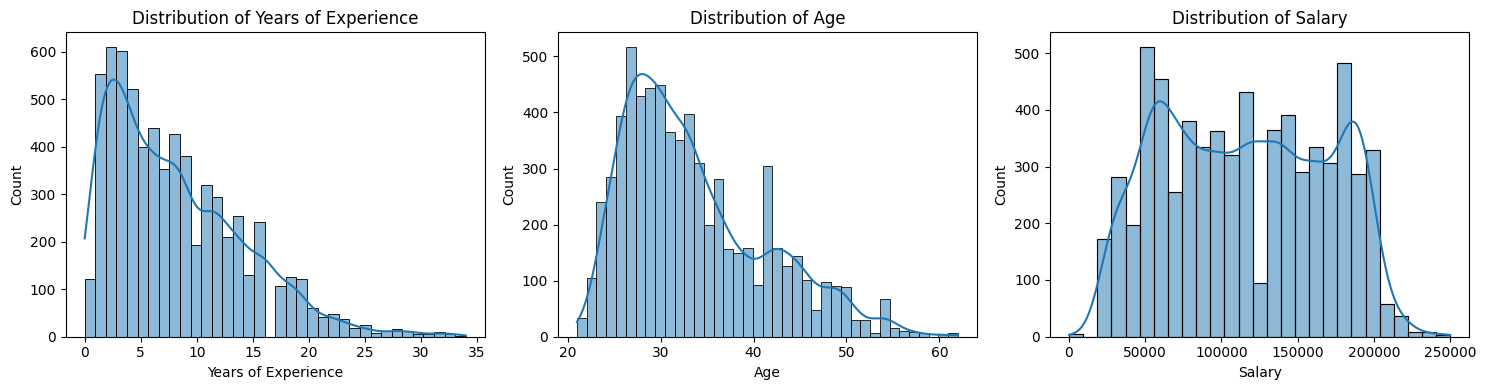

In [444]:
plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
sns.histplot(df['Years of Experience'], kde=True)
plt.title("Distribution of Years of Experience")

plt.subplot(1, 3, 2)
sns.histplot(df['Age'].dropna(), kde=True)
plt.title("Distribution of Age")

plt.subplot(1, 3, 3)
sns.histplot(df['Salary'].dropna(), kde=True)
plt.title("Distribution of Salary")

plt.tight_layout()

plt.show()

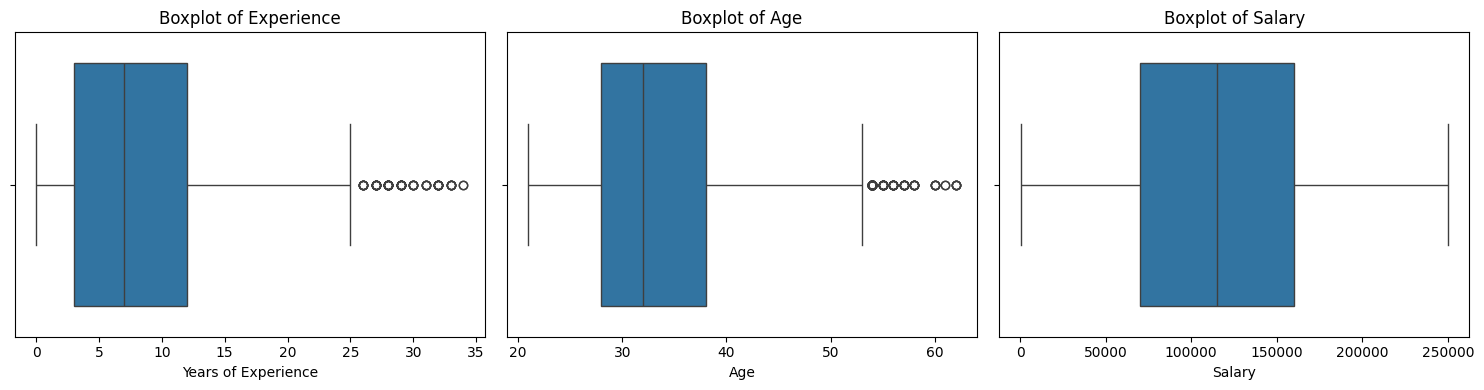

In [445]:
plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
sns.boxplot(x=df['Years of Experience'].dropna())
plt.title("Boxplot of Experience")

plt.subplot(1, 3, 2)
sns.boxplot(x=df['Age'].dropna())
plt.title("Boxplot of Age")

plt.subplot(1, 3, 3)
sns.boxplot(x=df['Salary'].dropna())
plt.title("Boxplot of Salary")

plt.tight_layout()
plt.show()

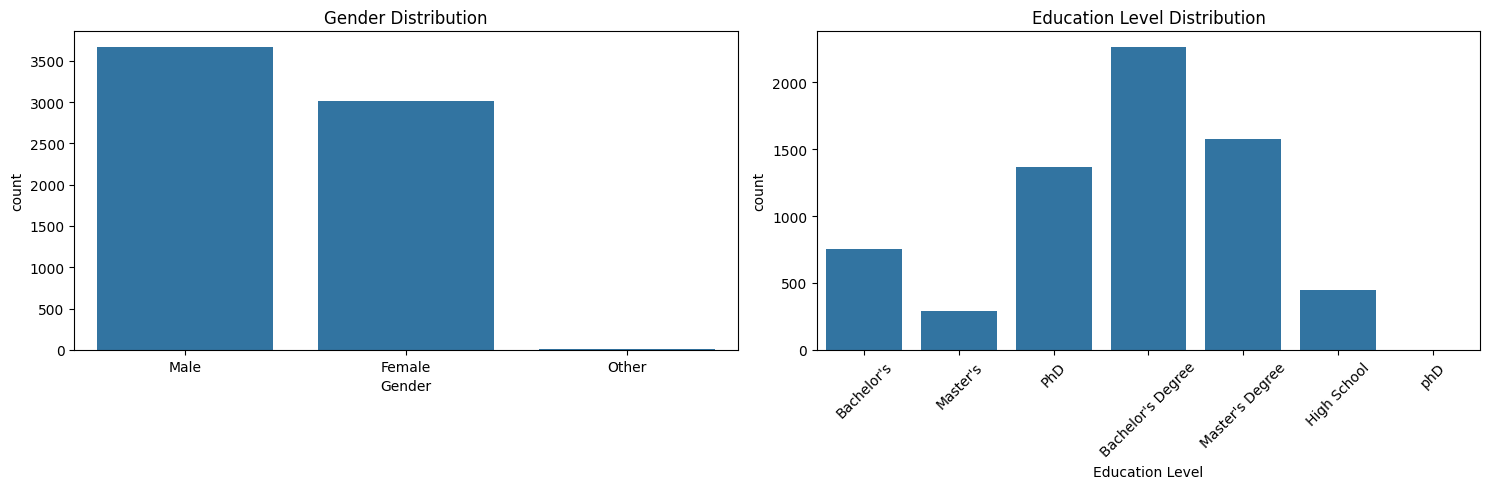

In [446]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.countplot(x='Gender', data=df)
plt.title("Gender Distribution")

plt.subplot(1, 2, 2)
sns.countplot(x='Education Level', data=df)
plt.xticks(rotation=45)
plt.title("Education Level Distribution")

plt.tight_layout()
plt.show()

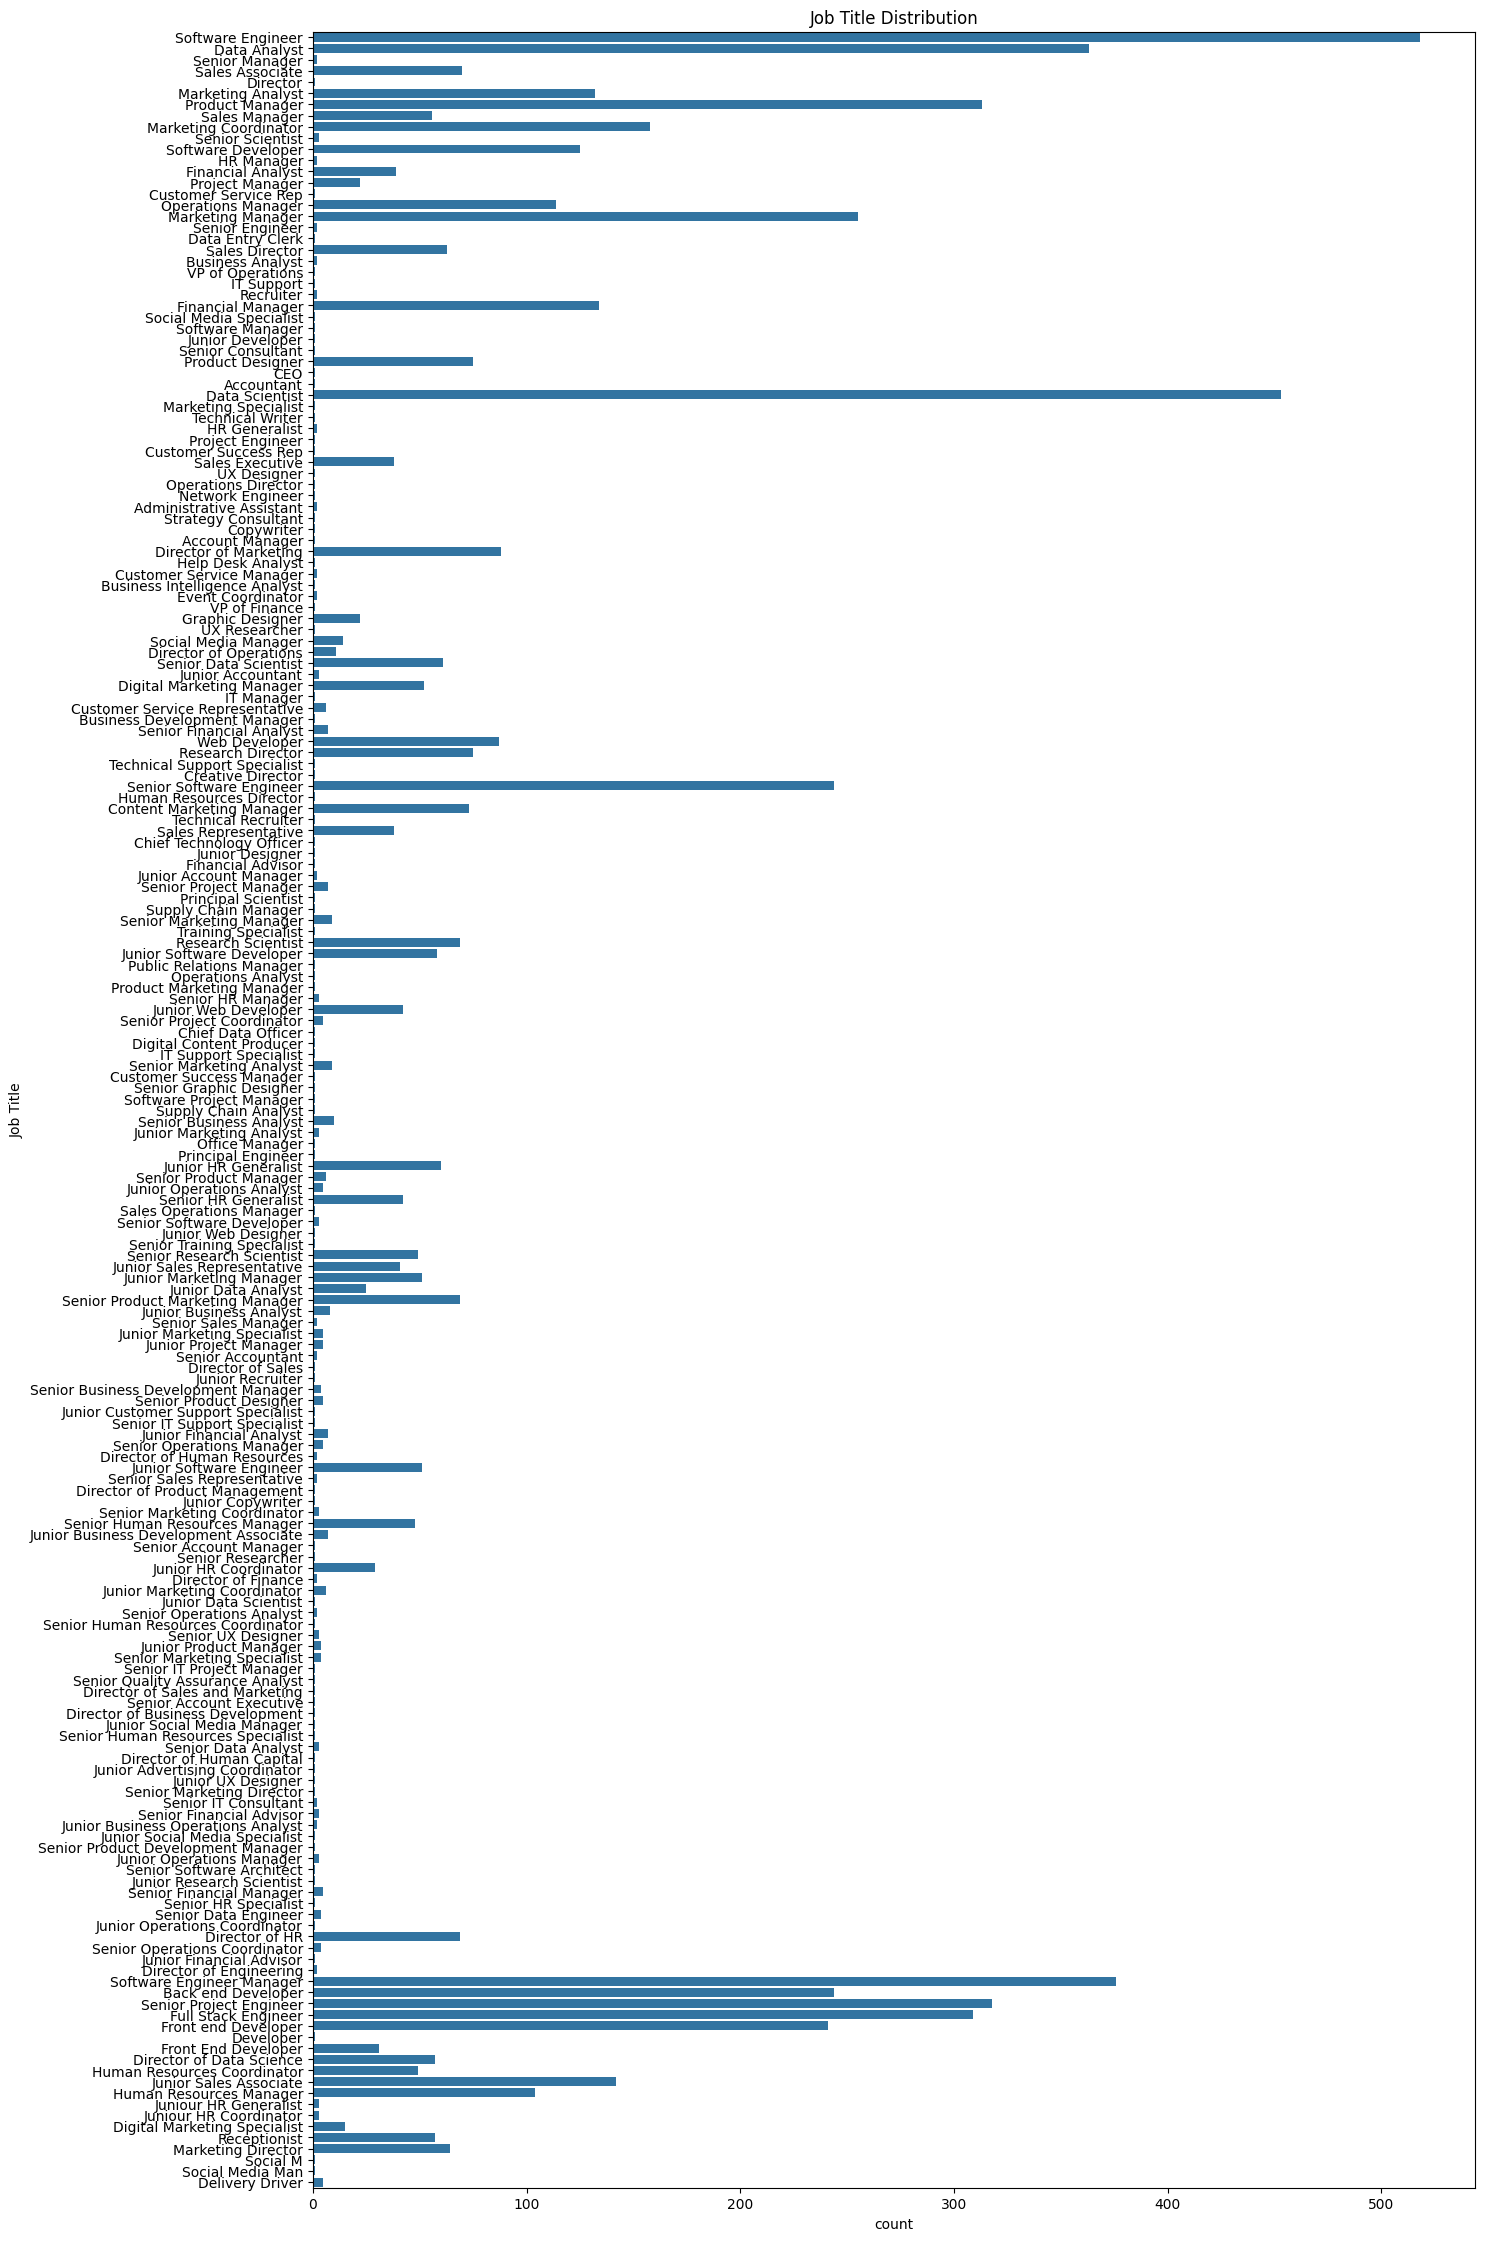

In [447]:
plt.figure(figsize=(15,28))
sns.countplot(y='Job Title', data=df)
plt.title("Job Title Distribution")
plt.show()

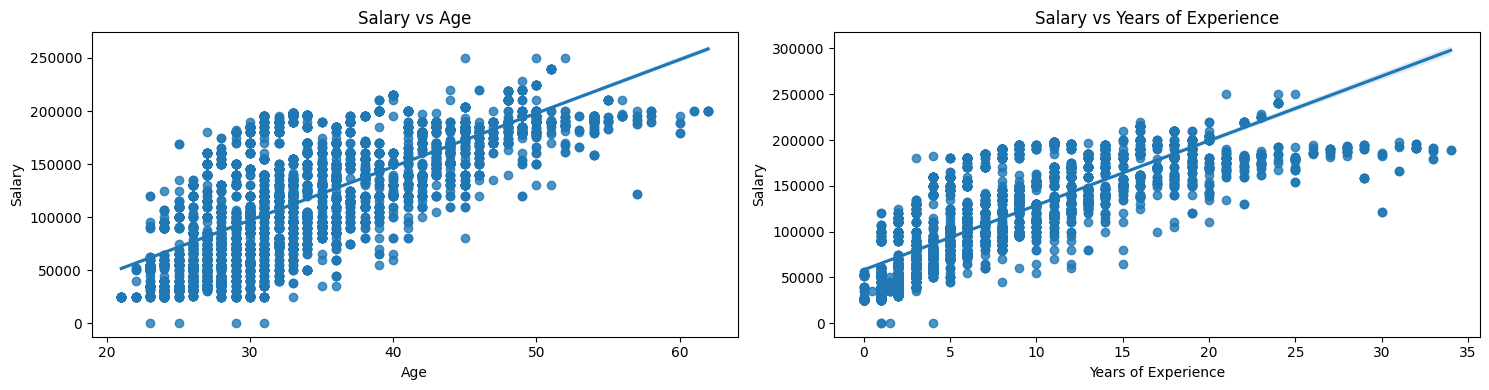

In [448]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
sns.regplot(x='Age', y='Salary', data=df)
plt.title("Salary vs Age")

plt.subplot(1, 2, 2)
sns.regplot(x='Years of Experience', y='Salary', data=df)
plt.title("Salary vs Years of Experience")
plt.tight_layout()

plt.show()

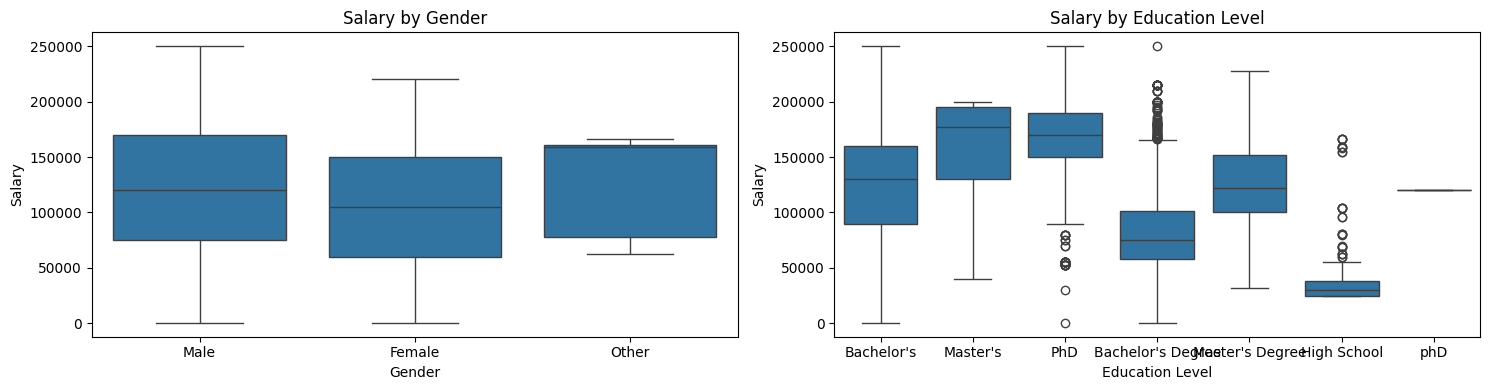

In [449]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
sns.boxplot(x='Gender', y='Salary', data=df)
plt.title("Salary by Gender")

plt.subplot(1, 2, 2)
sns.boxplot(x='Education Level', y='Salary', data=df)
plt.title("Salary by Education Level")

plt.tight_layout()
plt.show()

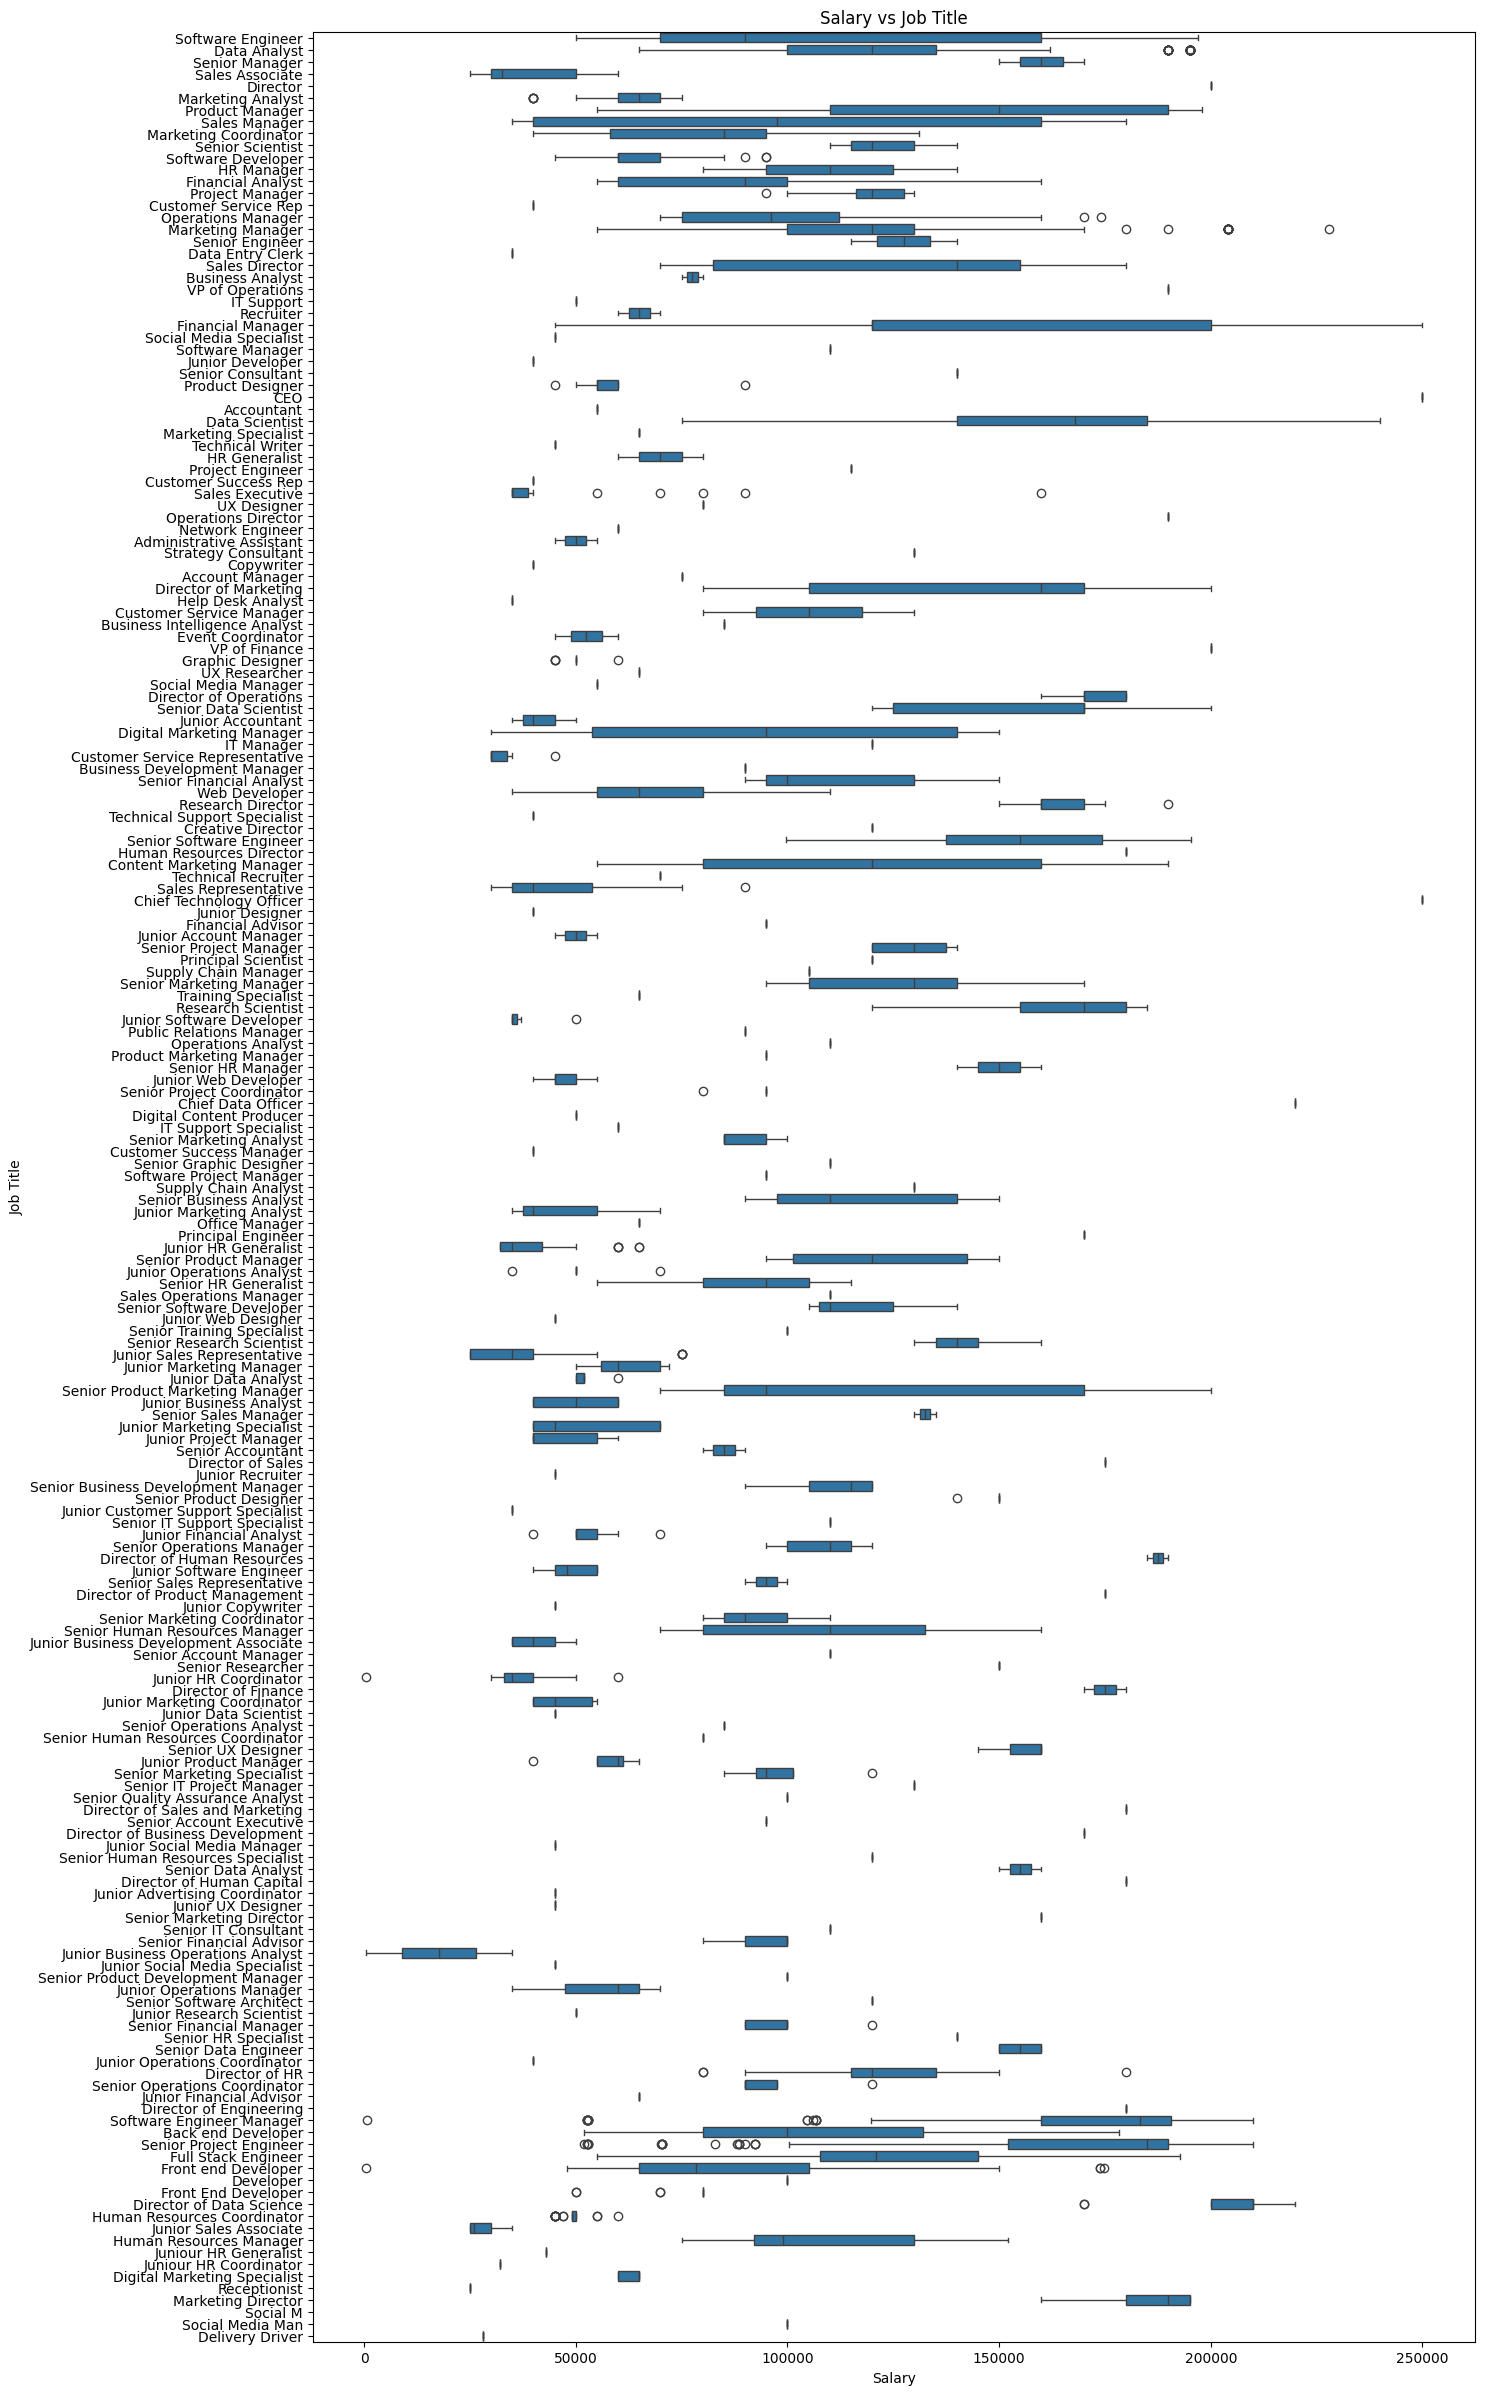

In [450]:
plt.figure(figsize=(15,30))
sns.boxplot(y='Job Title', x='Salary', data=df)
plt.title("Salary vs Job Title")

plt.show()


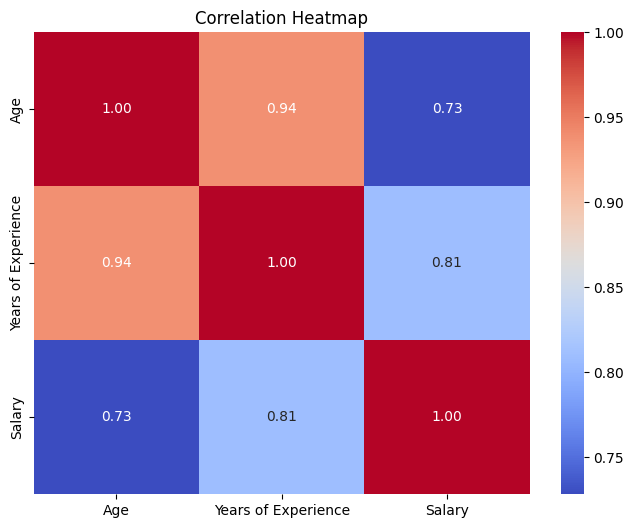

In [451]:
plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

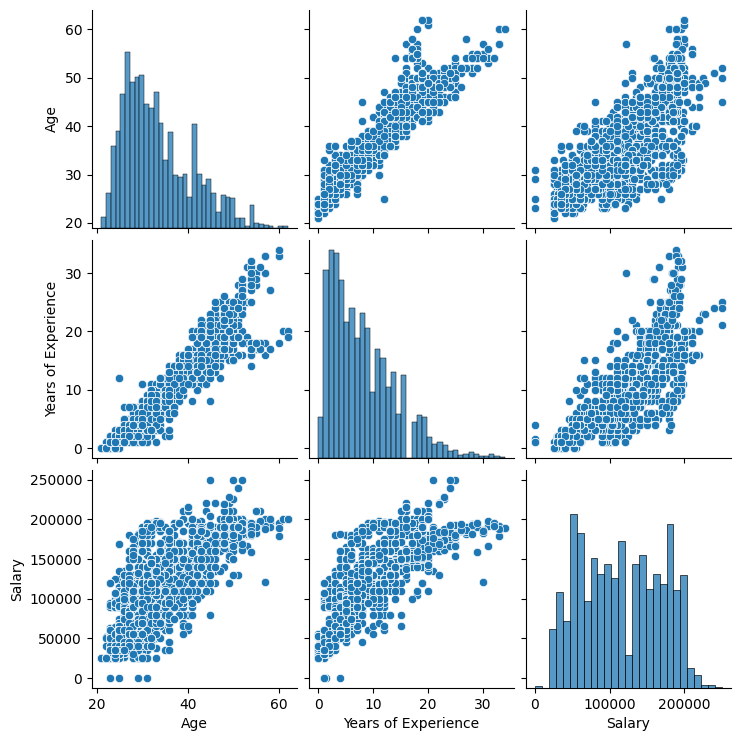

In [452]:
sns.pairplot(df)

##### Data Cleaning

In [453]:
#drop null values
df = df.dropna()

#reset the DataFrame index after removing duplicates
df = df.reset_index(drop=True)  


In [454]:
#handle inconsistent data values in the 'Education Level' column
def clean_text(text):
    if isinstance(text,str):
        text = text.strip().lower()
        text = text.replace("’","'")
        text = text.replace(" degree","")
        text = text.replace("bachelors", "bachelor's")
        text = text.replace("masters", "master's")
        text = text.replace("phd", "phd")
        text = text.title()
    return text

df['Education Level'] = df['Education Level'].apply(clean_text)    
 

In [455]:
#remove duplicate rows from the DataFrame 
df.drop_duplicates(inplace=True)

#reset the DataFrame index after removing duplicates
df = df.reset_index(drop=True)


In [456]:
#remove outliers in salary column
Q1 = df['Salary'].quantile(0.25)
Q3 = df['Salary'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#remove unrealistic salaries
df = df[(df['Salary'] >= lower_bound) & (df['Salary'] <= upper_bound) & (df['Salary'] > 1000)]

#reset the DataFrame index after removing duplicates
df = df.reset_index(drop=True)


##### Final EDA

In [457]:
#number of rows and columns after cleaning the dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 1782
Number of columns: 6


In [458]:
#statistical summary after cleaning the dataset
print(df.describe())

               Age  Years of Experience         Salary
count  1782.000000          1782.000000    1782.000000
mean     35.160494             9.175365  113473.068462
std       8.213535             6.844464   51369.548989
min      21.000000             0.000000   25000.000000
25%      29.000000             3.000000   70000.000000
50%      33.000000             8.000000  110353.500000
75%      41.000000            13.000000  160000.000000
max      62.000000            34.000000  250000.000000


In [459]:
#check that all nulls are removed after cleaning the dataset
print(df.isnull().sum())

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64


In [460]:
#check that duplicates are removed after cleaning the dataset
print("Duplicates after cleaning: ",df.duplicated().sum())

Duplicates after cleaning:  0


In [461]:
#Check that text inconsistencies have been fixed in the 'Education Level' column 
print(df['Education Level'].unique())

["Bachelor'S" "Master'S" 'Phd' 'High School']


In [462]:
#check that outliers are removed after cleaning the dataset
print("All Salary column data > 1000: ",(df['Salary'] > 1000).all())
    

All Salary column data > 1000:  True


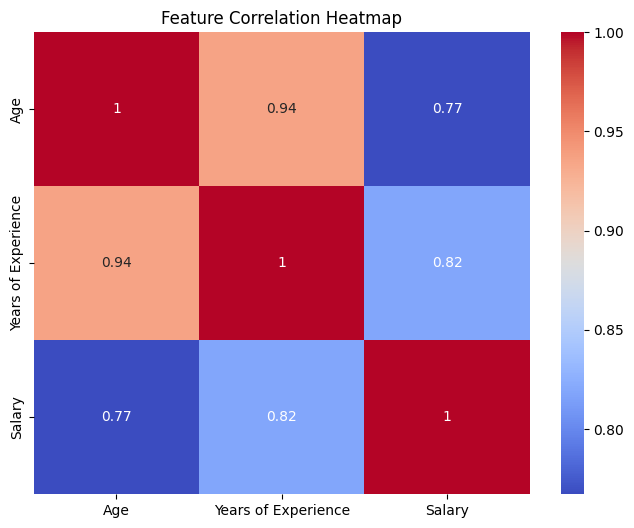

In [463]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

##### Feature and Target Separation

In [464]:
X = df.drop('Salary', axis=1)
y = df['Salary']

##### Splitting Data

In [465]:
#split data 80% to train and 20% for test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


##### Handle Rare Categories

In [466]:
#handle rare categories
categorical_cols = ['Job Title', 'Education Level']
threshold = 10
for col in categorical_cols:
    top_categories = X_train[col].value_counts().loc[lambda x: x >= threshold].index
    X_train[col] = X_train[col].where(X_train[col].isin(top_categories), 'Other')
    X_test[col] = X_test[col].where(X_test[col].isin(top_categories), 'Other')

##### Preprocessing and Pipeline Setup

In [467]:
numeric_cols = ['Age', 'Years of Experience']

#preprocessor: encode categorical features, scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

#full pipeline: preprocessing + linear regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])


##### Cross Validation and Fit Pipeline

In [468]:
#perform 5-fold cross-validation on training data
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
print("Cross Validation R2 Scores:", scores)
print(f"Mean Cross Validation R2 Score: {scores.mean():.4f}")

#fit pipeline for training data
pipeline.fit(X_train, y_train)

#train_r2 score
train_r2 = pipeline.score(X_train, y_train)
print(f"Training R²: {train_r2:.4f}")


Cross Validation R2 Scores: [0.80656218 0.80255188 0.80343261 0.85038938 0.83065672]
Mean Cross Validation R2 Score: 0.8187
Training R²: 0.8298


##### Test Set  Evaluation

In [469]:
#predict on test set
y_pred = pipeline.predict(X_test)

#evaluation metrics
test_r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

#print results with explanation
print("=== Model Evaluation ===")

#test_r2 score
print(f"Test_R² Score: {test_r2:.4f}")

if test_r2 > 0.7:
    print(f"Model explains {test_r2*100:.2f}% of the variance: good fit!\n")
elif 0.5 < test_r2 < 0.7:
    print(f"Model explains {test_r2*100:.2f}% of the variance: moderate fit!\n")
else:
    print(f"Model explains {test_r2*100:.2f}% of the variance: poor fit!\n")

#rmse
print(f"RMSE: {rmse:.2f}")
print(f"On average, predictions deviate by ~{rmse:.0f} from actual salaries.")

=== Model Evaluation ===
Test_R² Score: 0.8061
Model explains 80.61% of the variance: good fit!

RMSE: 22598.37
On average, predictions deviate by ~22598 from actual salaries.


#####  Residuals Analysis

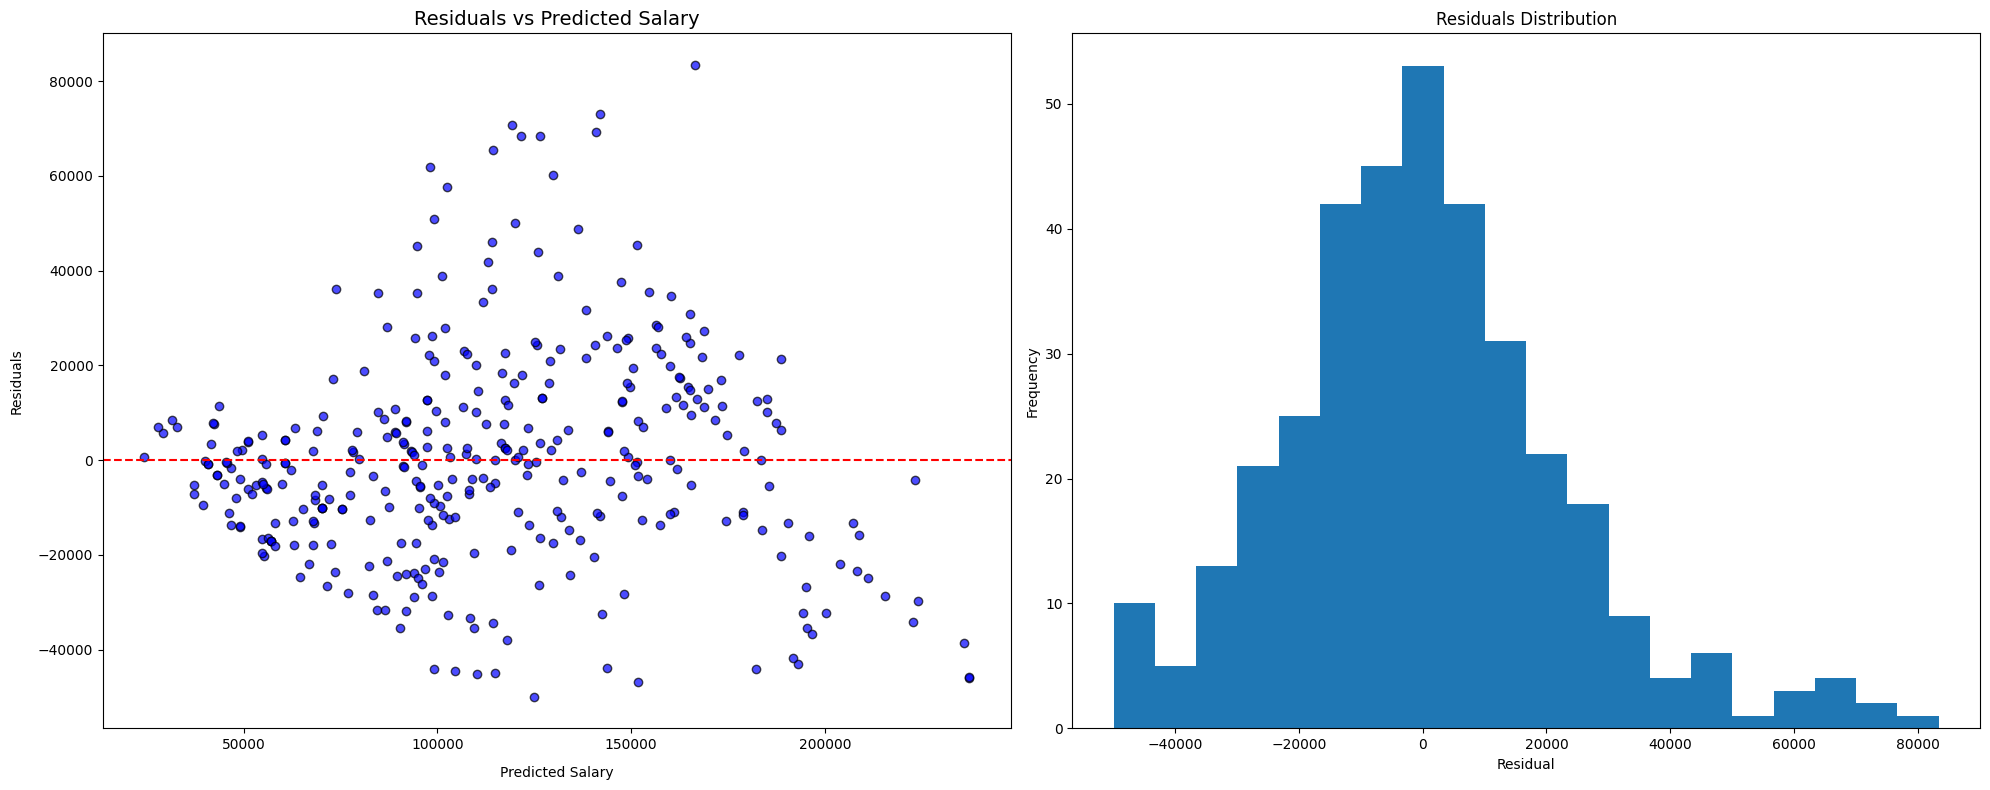

In [470]:
#calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(20,8))
#residuals vs Predicted plot

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Salary", labelpad=10)
plt.ylabel("Residuals", labelpad=10)
plt.title("Residuals vs Predicted Salary", loc='center', fontsize=14)


#histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20)
plt.subplot(1, 2, 2)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")


plt.tight_layout()
plt.show()

##### Save Model